<a href="https://colab.research.google.com/github/S3rg1t0/heart_mfcc/blob/main/Heartmfcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importación de librerías
import pandas as pd
import librosa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

!apt-get install -y unrar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unrar is already the newest version (1:5.6.6-2build1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


# **Descompresión de los datos**

Se descomprimen los datos set_a y set_b donde residen los archivos de audio de los diferentes audios 

In [2]:
!unrar x "/content/set_a.rar" 


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/set_a.rar

Creating    set_a                                                     OK
Extracting  set_a/artifact__201012172012.wav                               0%  OK 
Extracting  set_a/artifact__201105040918.wav                               1%  OK 
Extracting  set_a/artifact__201105041959.wav                               1%  OK 
Extracting  set_a/artifact__201105051017.wav                               2%  OK 
Extracting  set_a/artifact__201105060108.wav                               3%  OK 
Extracting  set_a/artifact__201105061143.wav                               3%  OK 
Extracting  set_a/artifact__201105190800.wav                               4%  OK 
Extracting  set_a/artifact__201105280851.wav                               4%  OK 
Extracting  set_a/artifact__201106010559.wav                               

In [3]:
!unrar x "/content/set_b.rar"


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/set_b.rar

Creating    set_b                                                     OK
Extracting  set_b/Bunlabelledtest__101_1305030823364_A.wav                 0%  OK 
Extracting  set_b/Bunlabelledtest__101_1305030823364_D.wav                 0%  OK 
Extracting  set_b/Bunlabelledtest__101_1305030823364_F.wav                 0%  OK 
Extracting  set_b/Bunlabelledtest__103_1305031931979_A.wav                 0%  OK 
Extracting  set_b/Bunlabelledtest__103_1305031931979_C.wav                 1%  OK 
Extracting  set_b/Bunlabelledtest__105_1305033453095_B.wav                 1%  OK 
Extracting  set_b/Bunlabelledtest__105_1305033453095_D.wav                 1%  OK 
Extracting  set_b/Bunlabelledtest__106_1306776721273_B.wav                 1%  OK 
Extracting  set_b/Bunlabelledtest__106_1306776721273_D.wav                 

# **Tratamiento archivos csv**

Los archivos csv proporcionados nos indica cada archivo a que etiqueta dispone.

Se realiza un análisis previo de los archivos para su mejor comprensión para visualizar a que nos enfrentamos.

## ***Visualización de los archivos csv***

Para la visualización de los archivos csv se apoyará con la ayuda de la librería pandas, la que nos ayudará a visualizar y tratar los datos

In [4]:
# Conversión de los archivos csv a dataframes de la librería pandas
set_a_csv = pd.read_csv("./set_a.csv")
set_b_csv = pd.read_csv("./set_b.csv")


### ***Visualización de los dataframes de los archivos csv***

Vista previa de los dataframes


In [5]:
# Visualición de etiquetado set_a
set_a_csv

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
...,...,...,...,...
171,a,set_a/__201108222241.wav,NaN,NaN
172,a,set_a/__201108222244.wav,NaN,NaN
173,a,set_a/__201108222247.wav,NaN,NaN
174,a,set_a/__201108222254.wav,NaN,NaN


In [6]:
# Visualición de etiquetado set_b
set_b_csv

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN
...,...,...,...,...
651,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
652,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
653,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
654,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal


### ***Valores únicos de nuestras tablas***

Representación de los valores únicos que muestran las diferentes opciones que nos plantean en nuestros datos

In [7]:
# Valores únicos de la columna label del set_a
set_a_csv["label"].unique()

array(['artifact', 'extrahls', 'murmur', 'normal', nan], dtype=object)

In [8]:
# Valores únicos de la columna label del set_b
set_b_csv["label"].unique()

array(['extrastole', 'murmur', 'normal', nan], dtype=object)

### ***Muestras que contienen de cada tipo nuestras tablas***

Se visualiza que el set_a contiene muy pocos datos respecto al set_b

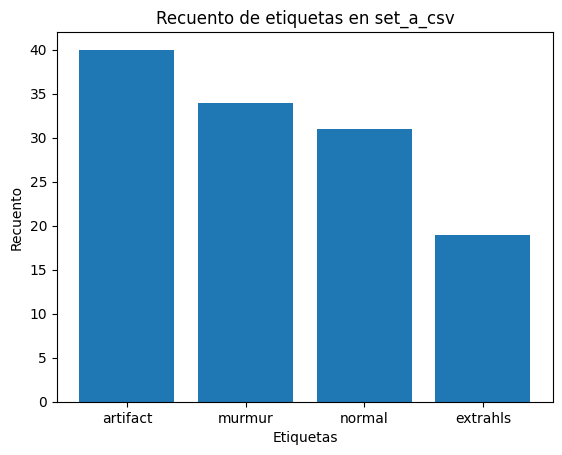

In [10]:
# Obtén los recuentos de valores de la columna "label" del set a
value_counts = set_a_csv["label"].value_counts()

# Crea la gráfica de barras
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Etiquetas")
plt.ylabel("Recuento")
plt.title("Recuento de etiquetas en set_a_csv")
plt.show()

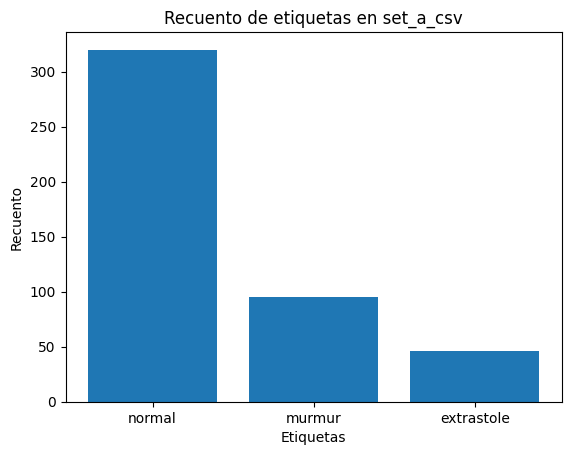

In [11]:
# Obtén los recuentos de valores de la columna "label" del set b
value_counts = set_b_csv["label"].value_counts()

# Crea la gráfica de barras
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Etiquetas")
plt.ylabel("Recuento")
plt.title("Recuento de etiquetas en set_a_csv")
plt.show()

### ***Agrupamiento de los datos***

Se agrupan los datos de nuestros datasets, ya que el set_a contiene tan pocos datos pero nos ofrece más datos sobre otras enfermedades.

In [14]:
# Agrupamiento
df = pd.concat([set_a_csv, set_b_csv])
df

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
...,...,...,...,...
651,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
652,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
653,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
654,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal


## **Tratamiento previo de los datos**

### Filtrado de las columnas 

Se recoge las columnas interesadas que son las columnas "fname" y "label" las cuales contienen las ubicaciones de los archivos y el etiquetado del archivo correspondientes. 

In [15]:
# Filtramos los datos que nos interesa, las columnas 'fname' y 'label'
data = df.iloc[:, 1:3]
data

,fname,label
0,set_a/artifact__201012172012.wav,artifact
1,set_a/artifact__201105040918.wav,artifact
2,set_a/artifact__201105041959.wav,artifact
3,set_a/artifact__201105051017.wav,artifact
4,set_a/artifact__201105060108.wav,artifact
...,...,...
651,set_b/Btraining_normal_Btraining_noisynormal_2...,normal
652,set_b/Btraining_normal_Btraining_noisynormal_2...,normal
653,set_b/Btraining_normal_Btraining_noisynormal_2...,normal
654,set_b/Btraining_normal_Btraining_noisynormal_2...,normal


### Eliminación de los datos nulos

Se eliminan los datos Nan que están en las etiquetas, ya que no nos aportan nada.

In [16]:
# Eliminamos las filas donde no tenemos etiquetados los datos
data.dropna(inplace=True)
data["label"].unique()

array(['artifact', 'extrahls', 'murmur', 'normal', 'extrastole'],
      dtype=object)

### ***Preparación de los directorios de los archivos***

Al analizar los datos se aprecia que hay una serie de diferencias entre los archivos de audios y los directorios que contienen el dataframe. 

In [17]:
# Preparamos la columna fname que coincida con las rutas
data["fname"] = data["fname"].str.replace("Btraining_","")
data["fname"] = data["fname"].str.replace("extrastole_","extrastole__")
data["fname"] = data["fname"].str.replace("murmur_1","murmur__1")
data["fname"] = data["fname"].str.replace("murmur_2","murmur__2")
data["fname"] = data["fname"].str.replace("normal_1","normal__1")
data["fname"] = data["fname"].str.replace("normal_2","normal__2")
data["fname"] = data["fname"].str.replace("normal_3","normal__3")
data["fname"] = data["fname"].str.replace("noisymurmur__","noisymurmur_")
data["fname"] = data["fname"].str.replace("noisynormal__","noisynormal_")

## **Preprocesamiento de los datos**

Realización de un preprocesamiento de los datos antes de la creación del modelo.


*   División del dataset en subsets de entrenamiento, test y validación.
*   Preparación de X
*   Preparación de y



### ***División de los datos***

División de los datos en subset de entrenamiento (70%), subset de validación(15%) y subset de test(15%) para su posterior uso en el entrenamiento del modelo

In [18]:
# Divison del dataset
train_subset, test_subset = train_test_split(data, test_size=0.3, random_state=1983)
val_subset, test_subset = train_test_split(test_subset, test_size=0.5, random_state=1983)

### ***Preparación de X***

Se crea una función para el procesamiento de los audios, los cuales se convierten en coeficientes cepstrales de mel (MFCC), es una escala de valores respecto al tiempo los cuales tratan de identificar la manera que tenemos de escuchar los audios.

In [19]:
# Función mfcc
def crear_mfcc(fname, max_pad_len = 100):
  """
  Función que convierte los audios en mfcc. Realizamos un tratamiento donde adaptamos los mfcc al mismo tamaño para evitar que los audios sean de diferentes duraciones
  fname: directorio del audio
  max_pad_len: longitud del audio máximo que aceptaremos, menores añadiremos 0 y si es más lo truncaremos.

  return mfcc: resultado de mfcc tras su procesamiento
  """
  y, sr = librosa.load(str(fname))
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

  # Si el audio es más corto que max_pad_len, rellenamos con ceros
  if (max_pad_len > mfcc.shape[1]):
      pad_width = max_pad_len - mfcc.shape[1]
      mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Si el audio es más largo, lo truncamos
  else:
      mfcc = mfcc[:, :max_pad_len]
  return mfcc

In [20]:
# Preparamos las X
X_train = np.array([crear_mfcc(fname) for fname in train_subset["fname"]])
X_val = np.array([crear_mfcc(fname) for fname in val_subset["fname"]])
X_test = np.array([crear_mfcc(fname) for fname in test_subset["fname"]])

In [21]:
# Dimensionamos las X para las capas convolucionales
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

### ***Preparación de y***

Binarizamos las etiquetas de la columna "label" en formato [0,0,0,0,1] para su procesamiento en el modelo

In [22]:
# Preparamos las y
le = LabelBinarizer()
y_train = le.fit_transform(train_subset["label"])
y_val = le.transform(val_subset["label"])
y_test = le.transform(test_subset["label"])

# **Modelo**

Creación de un modelo donde se realizará a través de una red neuronal convolucional para poder extraer las características del audio y después una red conectada entre sí para su clasificación.

## ***Definición del modelo***

In [23]:
# Definir el modelo
model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer = l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer = l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax', kernel_regularizer = l2(0.02)))  # 5 categorías


## ***Compilación del modelo***

In [24]:
# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



## ***Entrenamiento***

In [25]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/500
13/13 [==============================] - 12s 31ms/step - loss: 36.5713 - accuracy: 0.3814 - val_loss: 11.3874 - val_accuracy: 0.6136
Epoch 2/500
13/13 [==============================] - 0s 15ms/step - loss: 15.0474 - accuracy: 0.3912 - val_loss: 7.7820 - val_accuracy: 0.6250
Epoch 3/500
13/13 [==============================] - 0s 9ms/step - loss: 8.8742 - accuracy: 0.3447 - val_loss: 7.9181 - val_accuracy: 0.5341
Epoch 4/500
13/13 [==============================] - 0s 9ms/step - loss: 7.9023 - accuracy: 0.4866 - val_loss: 7.6842 - val_accuracy: 0.6136
Epoch 5/500
13/13 [==============================] - 0s 7ms/step - loss: 7.5942 - accuracy: 0.5550 - val_loss: 7.2159 - val_accuracy: 0.6136
Epoch 6/500
13/13 [==============================] - 0s 7ms/step - loss: 7.2050 - accuracy: 0.5623 - val_loss: 7.0013 - val_accuracy: 0.6136
Epoch 7/500
13/13 [==============================] - 0s 6ms/step - loss: 7.1017 - accuracy: 0.5501 - val_loss: 6.6852 - val_accuracy: 0.6136
Epoch 8

## ***Predicción del modelo*** 

In [26]:
# Obtén las predicciones del modelo
y_pred = model.predict(X_test)

# Convierte las probabilidades en etiquetas de clase
y_pred_classes = np.argmax(y_pred, axis=1)

# Convierte las etiquetas de one-hot encoding a etiquetas de clase
y_test_classes = np.argmax(y_test, axis=1)

# Calcula la precisión del modelo
accuracy = np.sum(y_pred_classes == y_test_classes) / len(y_test_classes)
print("Test accuracy:", accuracy)


3/3 [==============================] - 0s 3ms/step
Test accuracy: 0.7386363636363636


## ***Matriz de confusión***

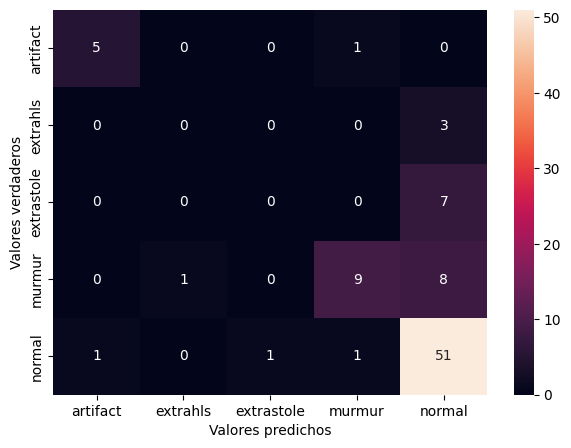

In [27]:

# Calcula la matriz de confusión
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# Dibuja la matriz de confusión
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.ylabel("Valores verdaderos")
plt.xlabel("Valores predichos")
plt.show()


## ***Guardar modelo***

In [ ]:
model.save("mfcc_heart_model.h5")

In [ ]:
with open('label_binarizer.pkl', 'wb') as f:
    pickle.dump(le, f)

# **Ejemplos de predicciones de los audios en bruto**

In [28]:
# Función para predecir el audio
def predict_audio(model, audio_path, label_binarizer, max_pad_len=100):
    # Cargar el audio
    y, sr = librosa.load(audio_path)

    # Extraer los coeficientes MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Padding/truncado
    
    if (max_pad_len > mfcc.shape[1]):
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]

    # Agregar una dimensión extra
    mfcc = mfcc[np.newaxis, ..., np.newaxis]

    # Hacer la predicción
    prediction = model.predict(mfcc)
    predicted_label = np.argmax(prediction)

    # Convertir la etiqueta numérica en su correspondiente etiqueta de clase
    predicted_class = label_binarizer.classes_[predicted_label]

    return predicted_class



### ***Ejemplo 1***

In [29]:
audio_path = '/content/set_b/murmur_noisymurmur_161_1307101199321_B.wav'
predicted_label = predict_audio(model, audio_path, le)
print('La etiqueta predicha es:', predicted_label)

1/1 [==============================] - 0s 54ms/step
La etiqueta predicha es: murmur


### ***Ejemplo 2***



In [ ]:
audio_path = '/content/set_a/artifact__201105060108.wav'
predicted_label = predict_audio(model, audio_path, le)
print('La etiqueta predicha es:', predicted_label)

1/1 [==============================] - 0s 32ms/step
La etiqueta predicha es: artifact


### ***Ejemplo 3***

In [ ]:
audio_path = "/content/set_b/extrastole__210_1308162935880_C.wav"
predicted_label = predict_audio(model, audio_path, le)
print('La etiqueta predicha es:', predicted_label)


1/1 [==============================] - 0s 30ms/step
La etiqueta predicha es: extrastole
